# Introduction to VPLS with PyEZ

* MAC learning required -- like switches, learn by source MAC and flooding of unknown dst MAC
* Basically a bunch of fully-meshed psuedowires under the hood, but with additional virtual-interfaces (lsi.123... or vt-x/x/x.0)
    * VT - Virtual Tunnel, requires tunnel services PIC and potentially two passes
    * LSI - Label-Switched Interface, only requires one pass
    * (I have questions about this still and its impact on throughput...)
* Component pseudowires can be signalled via BGP, LDP, or FEC129 (all tested below)
    * Kompella (BGP):
        * RFC 4761
        * offers auto-discovery and the ability to take advantage of Router-Reflectors
        * blocks of labels make advertisements efficient
        * No full mesh needed and highly scalable
        * AFI 25 (Layer-2 VPN) SAFI 65 (VPLS)
    * Martini (LDP-Signalled):
        * RFC 4762
        * Uses VPLS IDs
        * All peers must be manually configured
        * Targeted LDP sessions required
        * Lots of potential admin overheads but can be simplier
    * FEC129:
        * RFC 6074
        * Still has route-targets and RDs like BGP
        * Still has auto-discovery 
        * No label blocks equals more advertisements
* Customer interface no longer bound to a single pseudowire
* VPLS can be combined with IRB interfaces on PEs
    * IRBs can be configured with VRRP

###### A note on PyEZ:
* Add `set system services netconf ssh` to devices to enable NETCONF for PyEZ
* Some examples can be found here: https://github.com/Juniper/junosautomation/tree/master/pyez

## Configs

##### Client Facing Interface Config
* Option 1 (flexible ethernet services):
```
[edit interfaces ge-0/0/1]
set flexible-vlan-tagging
set encapsulation flexible-ethernet-services
set unit 100 encapsulation vlan-vpls
set unit 100 vlan-id 100
```

* Option 2 (physical interface can only run VPLS):
```
[edit interfaces ge-0/0/1]
set flexible-vlan-tagging
set encapsulation extended-vlan-vpls
set unit 100 family vpls
set unit 100 vlan-id 100
```

* Option 3 (physical interface can only run VPLS; legacy):
```
[edit interfaces ge-0/0/1]
set flexible-vlan-tagging
set encapsulation vlan-vpls     # Starts with VLAN 512 and above
set unit 600 family vpls
set unit 600 vlan-id 600
```

<h3 style='color:#6240AA; text-decoration:underline;'>BGP Kompella Signalled VPLS</h3>

##### BGP VPLS Config
```
[edit protocols bgp group INTERNAL]
set type internal
set local-address 1.1.1.1
set family l2vpn signaling  # Manually add in family inet unicast if needed -- otherwise this can remove it!
set neighbor 2.2.2.2        # Generally the RR

# OOB Route Reflectors
# Route Target Filtering

```

##### BGP VPLS Routing Instance Config
```
[edit routing-instances KOMPELLA_SIGNALLED_VPLS]
set instance-type vpls
set interface ge-0/0/1.100
set route-distinguisher 1.1.1.1:4242
set vrf-target target:64512:4242
set protocols vpls no-tunnel-services  # required if tunnel-services not enabled
set protocols vpls site ONE site-identifier 1
set protocols vpls site ONE interface ge-0/0/1.100

# Other options
set protocols vpls label-block-size < 2 | 4 | 8 | 16 >
```


<h3 style='color:#6240AA; text-decoration:underline;'>LDP-Signalled VPLS</h3>

* No BGP config needed
* Simplier Config
* All neighbors manually configured on all PEs
    * Can be error-prone and come with a heavy admin burden if not automated
```
[edit]
set protocols ldp interface lo0.0


[edit routing-instances LDP_SIGNALLED_VPLS]
set instance-type vpls
set interface ge-0/0/1.100
set protocols vpls no-tunnel-services  # required if tunnel-services not enabled
set protocols vpls vpls-id 12345
set protocols vpls neighbor 1.1.1.1
set protocols vpls neighbor 1.2.2.2
```



<h3 style='color:#6240AA; text-decoration:underline;'>FEC 129 Signalled VPLS</h3>

* No need to explicitly configure the SAII and TAII like for FEC129 psuedowires
    * Generated automatically based on local and remote PE IP

```
[edit protocols bgp group INTERNAL]
set type internal
set local-address 1.1.1.1
set family l2vpn auto-discovery-only
set neighbor 2.2.2.2        # Generally the RR
```

```
[edit routing-instances FEC129_SIGNALLED_VPLS]
set instance-type vpls
set interface ge-0/0/1.100
set route-distinguisher 1.1.1.1:4242
set vrf-target target:64512:4242
set l2vpn-id l2vpn-id:64512:4242
set protcols vpls no-tunnel-services  # required if tunnel-services not enabled
```

<h3 style='color:#6240AA; text-decoration:underline;'>VPLS Verification Commands</h3>


```
show bgp summary
show bgp table bgp.l2vpn.0 [match-prefix "<RD>:*"] [detail]
show bgp table <MY_INSTANCE>.l2vpn.0 [detail]
show vpls connections
show vpls connections [instance <MY_INSTANCE>] [extensive]
show vpls mac-table instance <MY_INSTANCE>

show route receive-protocol bgp 1.1.1.1

show ldp database
```












<h3 style='color:#6240AA; text-decoration:underline;'>VPLS VLAN Modes</h3>

* VLAN behavior the same regardless of signalling used
* VLANs used to multiplex different clients on a single physical or LAG interface (different from a broadcast domain anymore)
* Bridge Domain: a set of interfaces with the same flooding and forwarding characteristics
    * Single broadcast domain (like a VLAN but...)
    * But the broadcast domain is no not forcibly tied to or bound by a single VLAN number
    * Options:
      1) Define a VLAN number for the bridge domain (or explicitly configure no VLAN number). By default, PEs automatically swap VLANs to enable full mesh communication
      2) Make the VPLS VLAN aware. Separate bridge domain and MAC Tables per VLAN
      3) All interfaces in a single bridge domain / single broadcast domain, but VLAN tags are not normalized

#### "Default VPLS VLAN Mode"
* VLAN NA (Not Applicable)
* Probably not what you want or expect
* VLAN tags not changed to match other sub-interfaces; a tag that comes in with vlan 100 can be sent out with vlan 100 on a subinterface with a difference configured VLAN
```
set interfaces ge-0/0/8 flexible-vlan-tagging
set interfaces ge-0/0/8 encapsulation flexible-ethernet-services
set interfaces ge-0/0/8 unit 100 encapsulation vlan-vpls
set interfaces ge-0/0/8 unit 100 vlan-id 100

set interfaces ge-0/0/9 flexible-vlan-tagging
set interfaces ge-0/0/9 encapsulation flexible-ethernet-services
set interfaces ge-0/0/9 unit 200 encapsulation vlan-vpls           <---Frames from ge-0/0/8.100 would still be marked with VLAN 100 when sent out
set interfaces ge-0/0/9 unit 200 vlan-id 200                       <---VLAN 100 when sent out unit 200 -- the VLAN tag would not be normalized!!!
```

#### "Vlan-Aware VPLS Mode"
* Make separate brigde domains and MAC tables for each local VLAN in the VPLS
* Not advertised in the control plane; must be configured on each PE.
* **Cannot** be combined with IRB interfaces!!!
* One command needed
    * `set routing-instances MY_VLAN_AWARE_VPLS_INSTANCE vlan-id all`
    * Achtung! Uwaga! MAC table cleared when the command is applied!


#### "Vlan-Normalization VPLS Mode"
* VLAN tags are forwarded to all interfaces, but VLAN tags are normalized to match the VLAN configured on the relative interface
* Choose a random VLAN number for the entire VPLS
    * `set routing-instances MY_VLAN_NORMALIZATION_VPLS_INSTANCE vlan-id 4224`
    * Tags swapped to the selected VLAN on ingress and then normalized to the relative interface VLAN on egress
    * One bridge domain all in the configured VLAN


#### "No-VLAN VPLS Mode"
* VLAN tags are forwarded to all interfaces, but VLAN tags are normalized to match the VLAN configured on the relative attachment circuit
* Command
    * `set routing-instances MY_VLAN_NORMALIZATION_VPLS_INSTANCE vlan-id none`
    * Tags popped on ingress and then normalized to the relative interface VLAN on egress
    * One bridge domain with no VLAN


#### "Q-in-Q with VPLS"

* Outer tag may be added by and aggregator/wholesaler between the SP and the client.


```
# Basic Q-in-Q config 
set interfaces ge-0/0/8 unit 2100 encapsulation vlan-vpls
set interfaces ge-0/0/8 unit 2100 vlan-tags outer 2000 inner 100
```

* `set routing-instances MY_VLAN_AWARE_VPLS_INSTANCE vlan-id all`
    * Outer Tag does not matter and is popped; all attachment circuits with the same inner tag can communicate
* `set routing-instances MY_VLAN_AWARE_VPLS_INSTANCE vlan-id inner-all`
    * Outer Tag does matter and must match; all attachment circuits with the same outer and inner tag can communicate
    * Might be a better idea to create two separate VPLS instances
* `set routing-instances MY_VLAN_NORMALIZATION_VPLS_INSTANCE vlan-id 4224`
    * Pop-Swap the outer and inner on ingress and apply the local outer and inner tags on egress
* `set routing-instances MY_VLAN_NORMALIZATION_VPLS_INSTANCE vlan-tags outer 4224 inner 2442`
    * Normalize as directly above, but with stacked tags

#### Topology
* Running IS-IS as the IGP with LDP and MPLS already configured on all core interfaces
* The Cisco router is running VRFs and functions as both CE1 (gig 0/1 to ge-0/0/1) and CE2 (gig 0/2 to ge-0/0/2)
* Two additional CEs (ge-0/0/4) are configured as Logical-Systems on PE1 and PE2 (ge-0/0/3).
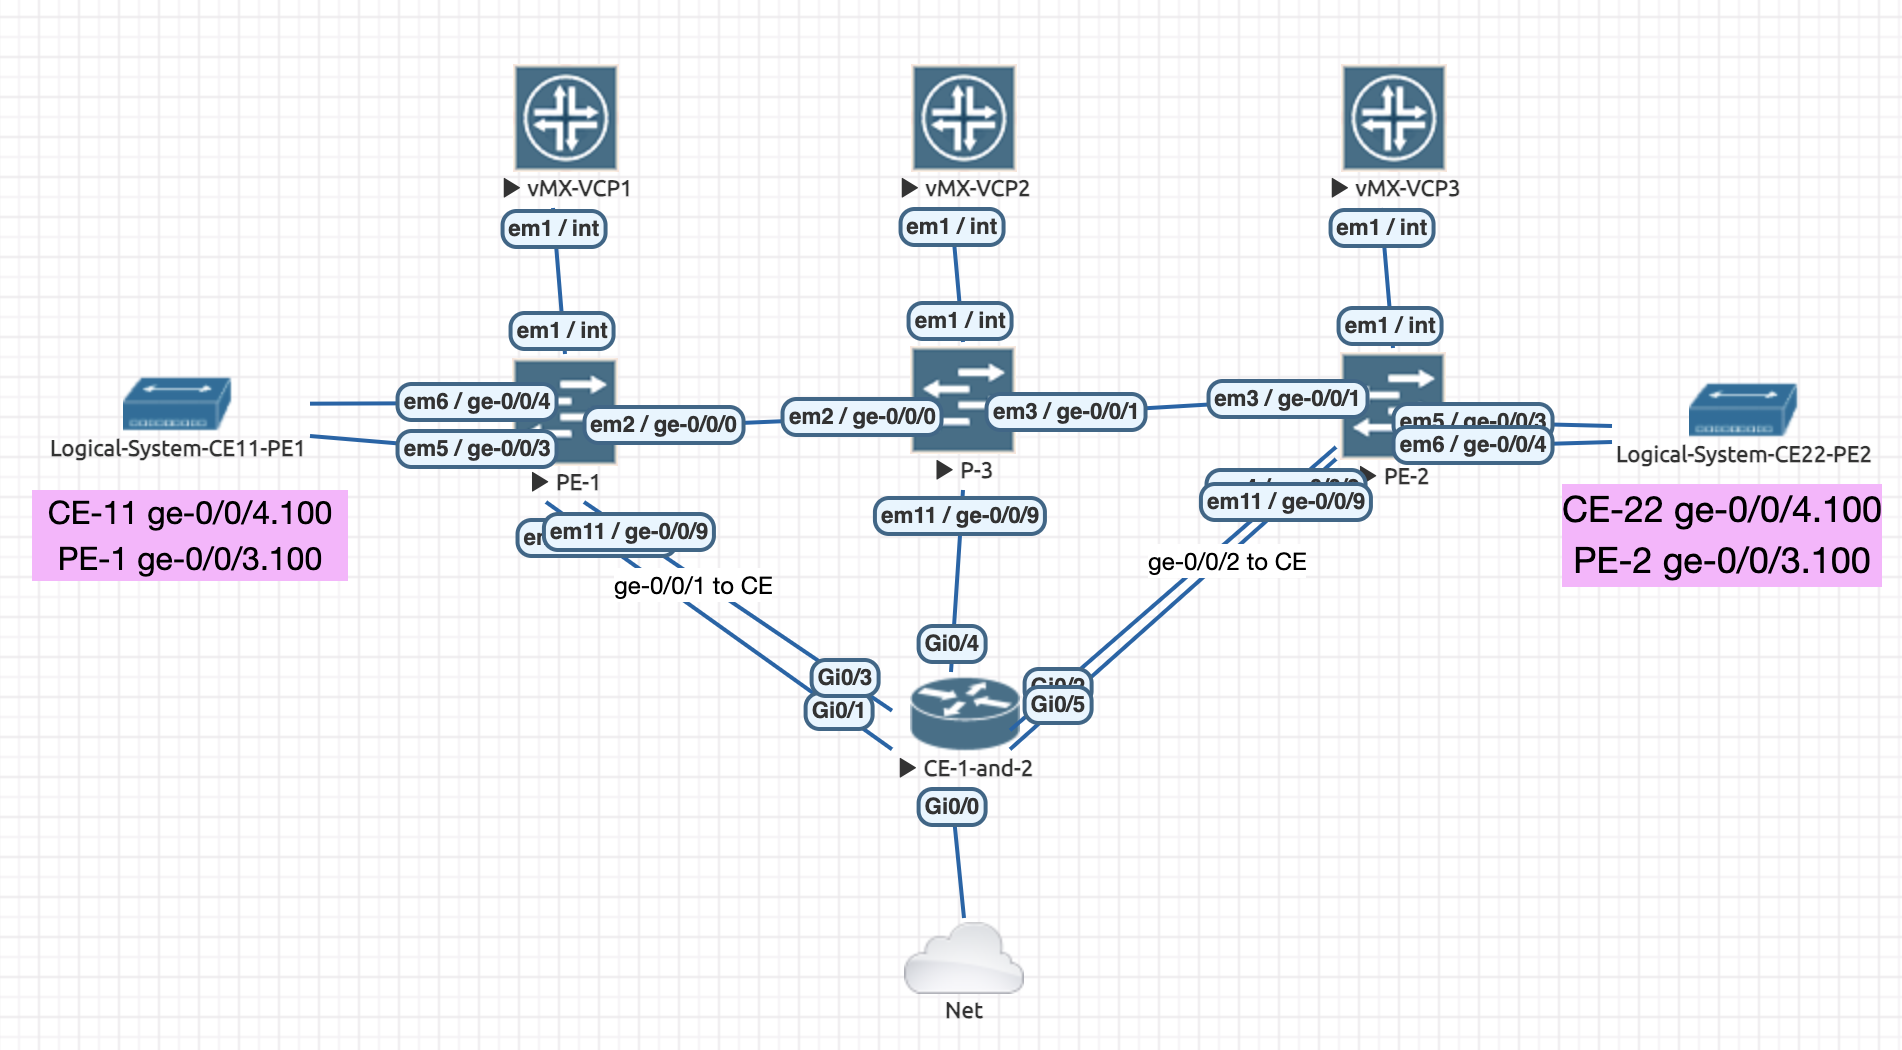

In [1]:
import configparser
from jnpr.junos import Device
from jnpr.junos.utils.config import Config
from pprint import pprint
from lxml import etree

# Load credentials and login info from .ini file
config = configparser.ConfigParser()
config.read("../logins.ini")

devices_login_info = {}
for device in config.sections():
    devices_login_info[device] = {}
    devices_login_info[device]["host"] = config[device]["host"]
    devices_login_info[device]["user"] = config[device]["username"]
    devices_login_info[device]["passwd"] = config[device]["password"]

loopback_pe1 = "1.1.1.1"
loopback_pe2 = "2.2.2.2"

In [2]:
for device, login_info in devices_login_info.items():
    try:
        globals()[device] = Device(**login_info)  # Assign key as variable name
        globals()[device].open()
        print(f"Creating PyEZ connection for {device}")
    except:
        print(f"Error connecting to {device}.")

Creating PyEZ connection for PE1
Creating PyEZ connection for P
Creating PyEZ connection for PE2


## Create Backup
* Probably a much cleaner way to write these functions ;)

In [3]:
def save_to_backup(device, file_name):
    cnf = device.rpc.get_config()
    with open(file_name, "wb") as file:
        file.write(etree.tostring(cnf))
        print(f"Config saved to {file_name}")

def load_backup(device, file_name):
    cu = Config(device)
    with open(file_name, "rb") as file:
        cnf = etree.fromstring(file.read())
    try:
        cu.load(cnf, overwrite=True)
        print('------------------------------------')
        print("Diff between current config:\n", cu.diff(), "\n")
        if cu.commit_check():
            cu.commit()
            print(f"Backup config {file_name} applied to {device.facts['hostname']}")
            print('------------------------------------\n')
        else:
            cu.rollback()
    except Exception as err:
        print(err)

In [4]:
save_to_backup(PE1, "PE1_pyez_base_config.xml")
save_to_backup(PE2, "PE2_pyez_base_config.xml")
save_to_backup(P, "P_pyez_base_config.xml")

Config saved to PE1_pyez_base_config.xml
Config saved to PE2_pyez_base_config.xml
Config saved to P_pyez_base_config.xml


In [5]:
load_backup(PE1, "PE1_pyez_base_config.xml")
load_backup(PE2, "PE2_pyez_base_config.xml")
load_backup(P, "P_pyez_base_config.xml")

------------------------------------
Diff between current config:
 None 

Backup config PE1_pyez_base_config.xml applied to PE-1
------------------------------------

------------------------------------
Diff between current config:
 None 

Backup config PE2_pyez_base_config.xml applied to PE-2
------------------------------------

------------------------------------
Diff between current config:
 None 

Backup config P_pyez_base_config.xml applied to P3
------------------------------------



#### Helper function to apply configs

In [6]:
from jnpr.junos.exception import ConfigLoadError, RPCError

def apply_set_config(device, config):
    cu = Config(device)
    #cu.unlock()
    #cu.lock()
    try:
        cu.load(config, format="set", merge=True)
        diffs = cu.diff()
        if diffs:
            print("Configuration changes:\n", diffs)
            cu.commit()
            print(f"Configuration applied successfully to {device.facts['hostname']}!")
        else:
            print("No changes detected.")
    except ConfigLoadError as err:
        print("Something wrong with the config commands. Check your syntax.")
        print(err)
    except RPCError as err:
        print("RPCError.")
        print(err)
    except Exception as err:
        print(err)
    #cu.unlock()

In [8]:
# Logical System configs for reference; should already be in the base config:
ce_11_logical_system_for_pe1 = """
set interfaces ge-0/0/4 flexible-vlan-tagging
set logical-systems CE11 interfaces ge-0/0/4 unit 100 vlan-id 100
set logical-systems CE11 interfaces ge-0/0/4 unit 100 family inet address 10.12.12.11/24
"""

ce_22_logical_system_for_pe2 = """
set interfaces ge-0/0/4 flexible-vlan-tagging
set logical-systems CE22 interfaces ge-0/0/4 unit 100 vlan-id 100
set logical-systems CE22 interfaces ge-0/0/4 unit 100 family inet address 10.12.12.22/24
"""

## Configure CE Facing Interfaces

In [9]:
pe_to_ce_interface_config = """
set interfaces {interface} description "PE-CE VPLS Interface"
set interfaces {interface} flexible-vlan-tagging
set interfaces {interface} encapsulation flexible-ethernet-services
set interfaces {interface} unit {vlan} encapsulation vlan-vpls
set interfaces {interface} unit {vlan} vlan-id {vlan}
"""

In [10]:
print("PE-1:")
apply_set_config(PE1, pe_to_ce_interface_config.format(interface="ge-0/0/1", vlan="200"))
apply_set_config(PE1, pe_to_ce_interface_config.format(interface="ge-0/0/3", vlan="100"))
print("PE-2:")
apply_set_config(PE2, pe_to_ce_interface_config.format(interface="ge-0/0/2", vlan="200"))
apply_set_config(PE2, pe_to_ce_interface_config.format(interface="ge-0/0/3", vlan="100"))

Configuration changes:
 
[edit interfaces ge-0/0/1]
-   description TO-CE1;
+   description "PE-CE VPLS Interface";
+   flexible-vlan-tagging;
+   encapsulation flexible-ethernet-services;
+   unit 200 {
+       encapsulation vlan-vpls;
+       vlan-id 200;
+   }

Configuration applied successfully to PE-1!
Configuration changes:
 
[edit interfaces]
+   ge-0/0/3 {
+       description "PE-CE VPLS Interface";
+       flexible-vlan-tagging;
+       encapsulation flexible-ethernet-services;
+       unit 100 {
+           encapsulation vlan-vpls;
+           vlan-id 100;
+       }
+   }

Configuration applied successfully to PE-1!
Configuration changes:
 
[edit interfaces ge-0/0/2]
-   description TO-CE2;
+   description "PE-CE VPLS Interface";
+   flexible-vlan-tagging;
+   encapsulation flexible-ethernet-services;
+   unit 200 {
+       encapsulation vlan-vpls;
+       vlan-id 200;
+   }

Configuration applied successfully to PE-2!
Configuration changes:
 
[edit interfaces]
+   ge-0/0/3 {

<h1 style='color:#007FFF; font-weight:bold; text-decoration:underline;'>Kompella Signalled VPLS</h1>

## Apply VPLS BGP Configuration

In [11]:
vpls_kompella_bgp_config = """
set protocols bgp group INTERNAL type internal
set protocols bgp group INTERNAL local-address {local_loopback}
set protocols bgp group INTERNAL family l2vpn signaling
set protocols bgp group INTERNAL neighbor {peer_loopback}
"""

In [12]:
apply_set_config(PE1, vpls_kompella_bgp_config.format(local_loopback="1.1.1.1", peer_loopback="2.2.2.2"))
apply_set_config(PE2, vpls_kompella_bgp_config.format(local_loopback="2.2.2.2", peer_loopback="1.1.1.1"))

Configuration changes:
 
[edit protocols]
+   bgp {
+       group INTERNAL {
+           type internal;
+           local-address 1.1.1.1;
+           family l2vpn {
+               signaling;
+           }
+           neighbor 2.2.2.2;
+       }
+   }

Configuration applied successfully to PE-1!
Configuration changes:
 
[edit protocols]
+   bgp {
+       group INTERNAL {
+           type internal;
+           local-address 2.2.2.2;
+           family l2vpn {
+               signaling;
+           }
+           neighbor 1.1.1.1;
+       }
+   }

Configuration applied successfully to PE-2!


## Apply VPLS Routing Instance Configuration

In [13]:
vpls_kompella_routing_instance_config = """
set routing-instances KOMPELLA_SIGNALLED_VPLS instance-type vpls
set routing-instances KOMPELLA_SIGNALLED_VPLS interface {interface}.{vlan}
set routing-instances KOMPELLA_SIGNALLED_VPLS route-distinguisher {local_loopback}:4242
set routing-instances KOMPELLA_SIGNALLED_VPLS vrf-target target:64512:4242
set routing-instances KOMPELLA_SIGNALLED_VPLS protocols vpls no-tunnel-services
set routing-instances KOMPELLA_SIGNALLED_VPLS protocols vpls site SITE_{site_id} site-identifier {site_id}
set routing-instances KOMPELLA_SIGNALLED_VPLS protocols vpls site SITE_{site_id} interface {interface}.{vlan}
"""


kompella_config_additional_interface = """
set routing-instances KOMPELLA_SIGNALLED_VPLS interface {interface}.{vlan}
set routing-instances KOMPELLA_SIGNALLED_VPLS protocols vpls site SITE_{site_id} interface {interface}.{vlan}
"""

In [14]:
apply_set_config(PE1, vpls_kompella_routing_instance_config.format(interface="ge-0/0/1", vlan="200",
                                                                   local_loopback="1.1.1.1", site_id="1"))
apply_set_config(PE2, vpls_kompella_routing_instance_config.format(interface="ge-0/0/2", vlan="200",
                                                                   local_loopback="2.2.2.2", site_id="2"))
apply_set_config(PE1, kompella_config_additional_interface.format(interface="ge-0/0/3", vlan="100", site_id="1"))
apply_set_config(PE2, kompella_config_additional_interface.format(interface="ge-0/0/3", vlan="100", site_id="2"))

Configuration changes:
 
[edit]
+  routing-instances {
+      KOMPELLA_SIGNALLED_VPLS {
+          instance-type vpls;
+          interface ge-0/0/1.200;
+          route-distinguisher 1.1.1.1:4242;
+          vrf-target target:64512:4242;
+          protocols {
+              vpls {
+                  no-tunnel-services;
+                  site SITE_1 {
+                      site-identifier 1;
+                      interface ge-0/0/1.200;
+                  }
+              }
+          }
+      }
+  }

Configuration applied successfully to PE-1!
Configuration changes:
 
[edit]
+  routing-instances {
+      KOMPELLA_SIGNALLED_VPLS {
+          instance-type vpls;
+          interface ge-0/0/2.200;
+          route-distinguisher 2.2.2.2:4242;
+          vrf-target target:64512:4242;
+          protocols {
+              vpls {
+                  no-tunnel-services;
+                  site SITE_2 {
+                      site-identifier 2;
+                      interface ge-0/0/2.200

### Verify VPLS

* Using Device.cli("my cli command") for now, but PyEZ lets you know that you really should be pulling back and parsing the XML. However, as I am just playing with PyEZ for now, I am setting the warning to False.
* Can ping across the VPLS from the Cisco router:
```
GW-CISCO#ping 10.10.10.2 source 10.10.10.1
Type escape sequence to abort.
Sending 5, 100-byte ICMP Echos to 10.10.10.2, timeout is 2 seconds:
Packet sent with a source address of 10.10.10.1 
.!!!!
Success rate is 100 percent (5/5), round-trip min/avg/max = 7/9/15 ms
GW-CISCO#
```

In [15]:
print(PE1.cli("show bgp summary", warning=False))
print(f"{'-'*80}\n"*3)
print(PE2.cli("show bgp summary", warning=False))


Groups: 1 Peers: 1 Down peers: 0
Table          Tot Paths  Act Paths Suppressed    History Damp State    Pending
bgp.l2vpn.0          
                       1          1          0          0          0          0
Peer                     AS      InPkt     OutPkt    OutQ   Flaps Last Up/Dwn State|#Active/Received/Accepted/Damped...
2.2.2.2               64512          7          8       0       0          12 Establ
  bgp.l2vpn.0: 1/1/1/0
  KOMPELLA_SIGNALLED_VPLS.l2vpn.0: 1/1/1/0

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


Groups: 1 Peers: 1 Down peers: 0
Table          Tot Paths  Act Paths Suppressed    History Damp State    Pending
bgp.l2vpn.0          
                       1          1          0          0          0          0
Peer                     AS      InPkt     OutPkt   

In [16]:
print(PE1.cli("show route table bgp.l2vpn.0", warning=False))
print(f"{'-'*80}\n"*3)
print(PE2.cli("show route table bgp.l2vpn.0", warning=False))



bgp.l2vpn.0: 1 destinations, 1 routes (1 active, 0 holddown, 0 hidden)
+ = Active Route, - = Last Active, * = Both

2.2.2.2:4242:2:1/96                
                   *[BGP/170] 00:00:12, localpref 100, from 2.2.2.2
                      AS path: I, validation-state: unverified
                    > to 10.1.3.3 via ge-0/0/0.0, Push 299792

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



bgp.l2vpn.0: 1 destinations, 1 routes (1 active, 0 holddown, 0 hidden)
+ = Active Route, - = Last Active, * = Both

1.1.1.1:4242:1:1/96                
                   *[BGP/170] 00:00:11, localpref 100, from 1.1.1.1
                      AS path: I, validation-state: unverified
                    > to 10.2.3.3 via ge-0/0/1.0, Push 299776



In [17]:
print(PE1.cli('show route table bgp.l2vpn.0 match-prefix "2.2.2.2:4242:*" detail', warning=False))
print(f"{'-'*80}\n"*3)
print(PE2.cli('show route table bgp.l2vpn.0 match-prefix "1.1.1.1:4242:*" detail', warning=False))



bgp.l2vpn.0: 1 destinations, 1 routes (1 active, 0 holddown, 0 hidden)
 2.2.2.2:4242:2:1/96 (1 entry, 0 announced)
        *BGP    Preference: 170/-101
                Route Distinguisher: 2.2.2.2:4242
                Next hop type: Indirect, Next hop index: 0
                Address: 0xc6336d0
                Next-hop reference count: 5
                Source: 2.2.2.2
                Protocol next hop: 2.2.2.2
                Indirect next hop: 0x2 no-forward INH Session ID: 0x0
                State: <Active Int Ext>
                Local AS: 64512 Peer AS: 64512
                Age: 13 	Metric2: 1 
                Validation State: unverified 
                Task: BGP_64512.2.2.2.2+179
                AS path: I 
                Communities: target:64512:4242 Layer2-info: encaps: VPLS, control flags:[0x0] , mtu: 0, site preference: 100
                Import Accepted
                Label-base: 262145, range: 8, offset: 1
                Localpref: 100
                Router ID: 

In [18]:
print(PE1.cli("show route table KOMPELLA_SIGNALLED_VPLS.l2vpn.0", warning=False))
print(f"{'-'*80}\n"*3)
print(PE2.cli("show route table KOMPELLA_SIGNALLED_VPLS.l2vpn.0", warning=False))



KOMPELLA_SIGNALLED_VPLS.l2vpn.0: 2 destinations, 2 routes (2 active, 0 holddown, 0 hidden)
+ = Active Route, - = Last Active, * = Both

1.1.1.1:4242:1:1/96                
                   *[L2VPN/170/-101] 00:00:16, metric2 1
                      Indirect
2.2.2.2:4242:2:1/96                
                   *[BGP/170] 00:00:15, localpref 100, from 2.2.2.2
                      AS path: I, validation-state: unverified
                    > to 10.1.3.3 via ge-0/0/0.0, Push 299792

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



KOMPELLA_SIGNALLED_VPLS.l2vpn.0: 2 destinations, 2 routes (2 active, 0 holddown, 0 hidden)
+ = Active Route, - = Last Active, * = Both

1.1.1.1:4242:1:1/96                
                   *[BGP/170] 00:00:14, localpref 100, from 1.1.1.1
                      

In [19]:
print(PE1.cli("show vpls connections", warning=False))
print(f"{'-'*80}\n"*3)
print(PE2.cli("show vpls connections", warning=False))


Layer-2 VPN connections:

Legend for connection status (St)   
EI -- encapsulation invalid      NC -- interface encapsulation not CCC/TCC/VPLS
EM -- encapsulation mismatch     WE -- interface and instance encaps not same
VC-Dn -- Virtual circuit down    NP -- interface hardware not present 
CM -- control-word mismatch      -> -- only outbound connection is up
CN -- circuit not provisioned    <- -- only inbound connection is up
OR -- out of range               Up -- operational
OL -- no outgoing label          Dn -- down                      
LD -- local site signaled down   CF -- call admission control failure      
RD -- remote site signaled down  SC -- local and remote site ID collision
LN -- local site not designated  LM -- local site ID not minimum designated
RN -- remote site not designated RM -- remote site ID not minimum designated
XX -- unknown connection status  IL -- no incoming label
MM -- MTU mismatch               MI -- Mesh-Group ID not available
BK -- Backup connection	

In [20]:
print(PE1.cli("show vpls connections instance KOMPELLA_SIGNALLED_VPLS extensive", warning=False))
print(f"{'-'*80}\n"*3)
print(PE2.cli("show vpls connections instance KOMPELLA_SIGNALLED_VPLS extensive", warning=False))


Layer-2 VPN connections:

Legend for connection status (St)   
EI -- encapsulation invalid      NC -- interface encapsulation not CCC/TCC/VPLS
EM -- encapsulation mismatch     WE -- interface and instance encaps not same
VC-Dn -- Virtual circuit down    NP -- interface hardware not present 
CM -- control-word mismatch      -> -- only outbound connection is up
CN -- circuit not provisioned    <- -- only inbound connection is up
OR -- out of range               Up -- operational
OL -- no outgoing label          Dn -- down                      
LD -- local site signaled down   CF -- call admission control failure      
RD -- remote site signaled down  SC -- local and remote site ID collision
LN -- local site not designated  LM -- local site ID not minimum designated
RN -- remote site not designated RM -- remote site ID not minimum designated
XX -- unknown connection status  IL -- no incoming label
MM -- MTU mismatch               MI -- Mesh-Group ID not available
BK -- Backup connection	

In [22]:
# Note `VLAN: NA`; using the default VPLS VLAN configuration -- likely not what we want
print(PE1.cli("show vpls mac-table instance KOMPELLA_SIGNALLED_VPLS", warning=False))
print(f"{'-'*80}\n"*3)
print(PE2.cli("show vpls mac-table instance KOMPELLA_SIGNALLED_VPLS", warning=False))



MAC flags       (S -static MAC, D -dynamic MAC, L -locally learned, C -Control MAC
    O -OVSDB MAC, SE -Statistics enabled, NM -Non configured MAC, R -Remote PE MAC, P -Pinned MAC)

Routing instance : KOMPELLA_SIGNALLED_VPLS
 Bridging domain : __KOMPELLA_SIGNALLED_VPLS__, VLAN : NA
   MAC                 MAC      Logical          NH     MAC         active
   address             flags    interface        Index  property    source
   50:00:00:04:00:06   D        ge-0/0/3.100    
   50:00:00:06:00:06   D        lsi.1048832     
   50:00:00:07:00:01   D        ge-0/0/1.200    
   50:00:00:07:00:02   D        lsi.1048832     

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



MAC flags       (S -static MAC, D -dynamic MAC, L -locally learned, C -Control MAC
    O -OVSDB MAC, SE -Statistics enabl

## Revert lab devices back to base config

In [23]:
load_backup(PE1, "PE1_pyez_base_config.xml")
load_backup(PE2, "PE2_pyez_base_config.xml")
load_backup(P, "P_pyez_base_config.xml")

------------------------------------
Diff between current config:
 
[edit interfaces ge-0/0/1]
-   description "PE-CE VPLS Interface";
-   flexible-vlan-tagging;
-   encapsulation flexible-ethernet-services;
-   unit 200 {
-       encapsulation vlan-vpls;
-       vlan-id 200;
-   }
+   description TO-CE1;
[edit interfaces]
-   ge-0/0/3 {
-       description "PE-CE VPLS Interface";
-       flexible-vlan-tagging;
-       encapsulation flexible-ethernet-services;
-       unit 100 {
-           encapsulation vlan-vpls;
-           vlan-id 100;
-       }
-   }
[edit protocols]
-   bgp {
-       group INTERNAL {
-           type internal;
-           local-address 1.1.1.1;
-           family l2vpn {
-               signaling;
-           }
-           neighbor 2.2.2.2;
-       }
-   }
[edit]
-  routing-instances {
-      KOMPELLA_SIGNALLED_VPLS {
-          instance-type vpls;
-          interface ge-0/0/1.200;
-          interface ge-0/0/3.100;
-          route-distinguisher 1.1.1.1:4242;
-

<h1 style='color:#007FFF; font-weight:bold; text-decoration:underline;'>LDP Signalled Style VPLS</h1>

## Reapply PE to CE interface config

In [26]:
print("\n\t----PE-1:----\n")
apply_set_config(PE1, pe_to_ce_interface_config.format(interface="ge-0/0/3", vlan="100"))
apply_set_config(PE1, pe_to_ce_interface_config.format(interface="ge-0/0/1", vlan="200"))
print("\n\t----PE-2:----\n")
apply_set_config(PE2, pe_to_ce_interface_config.format(interface="ge-0/0/2", vlan="200"))
apply_set_config(PE2, pe_to_ce_interface_config.format(interface="ge-0/0/3", vlan="100"))


	----PE-1:----

No changes detected.
No changes detected.

	----PE-2:----

No changes detected.
No changes detected.


## Add LDP to PE loopback

In [27]:
add_ldp_to_loopback_config = "set protocols ldp interface lo0.0"

apply_set_config(PE1, add_ldp_to_loopback_config)
apply_set_config(PE2, add_ldp_to_loopback_config)
print(PE1.cli("show ldp interface", warning=False))
print(f"{'-'*80}\n"*3)
print(PE2.cli("show ldp interface", warning=False))

Configuration changes:
 
[edit protocols ldp]
+    interface lo0.0;

Configuration applied successfully to PE-1!
Configuration changes:
 
[edit protocols ldp]
+    interface lo0.0;

Configuration applied successfully to PE-2!

Interface          Address                          Label space ID   Nbr   Next
                                                                    count  hello
ge-0/0/0.0         10.1.3.1                         1.1.1.1:0         1      3
lo0.0              1.1.1.1                          1.1.1.1:0         0      0

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


Interface          Address                          Label space ID   Nbr   Next
                                                                    count  hello
ge-0/0/1.0         10.2.3.2                    

## Set up routing instance for LDP signalled VPLS

In [30]:
ldp_signalled_vpls_routing_instance_config = """
set routing-instances LDP_SIGNALLED_VPLS instance-type vpls
set routing-instances LDP_SIGNALLED_VPLS interface {interface}.{vlan}
set routing-instances LDP_SIGNALLED_VPLS protocols vpls no-tunnel-services
set routing-instances LDP_SIGNALLED_VPLS protocols vpls vpls-id {vpls_id}
set routing-instances LDP_SIGNALLED_VPLS protocols vpls neighbor {peer_loopback}"""

ldp_signalled_additional_interface = "set routing-instances LDP_SIGNALLED_VPLS interface {interface}.{vlan}"

In [32]:
apply_set_config(PE1, ldp_signalled_vpls_routing_instance_config.format(interface="ge-0/0/1", vlan="200",
                                                                        vpls_id="42424", peer_loopback=loopback_pe2))
apply_set_config(PE2, ldp_signalled_vpls_routing_instance_config.format(interface="ge-0/0/2", vlan="200",
                                                                        vpls_id="42424", peer_loopback=loopback_pe1))
apply_set_config(PE1, ldp_signalled_additional_interface.format(interface="ge-0/0/3", vlan="100"))
apply_set_config(PE2, ldp_signalled_additional_interface.format(interface="ge-0/0/3", vlan="100"))

No changes detected.
No changes detected.
Configuration changes:
 
[edit routing-instances LDP_SIGNALLED_VPLS]
+    interface ge-0/0/3.100;

Configuration applied successfully to PE-1!
Configuration changes:
 
[edit routing-instances LDP_SIGNALLED_VPLS]
+    interface ge-0/0/3.100;

Configuration applied successfully to PE-2!


## Verify LDP signalled VPLS

In [34]:
print("PE1:")
print(PE1.cli("show ldp neighbor", warning=False))
print(PE1.cli("show ldp session", warning=False))
print(PE1.cli("show ldp database", warning=False))
print(f"{'-'*80}\n"*3)
print("PE2:")
print(PE2.cli("show ldp neighbor", warning=False))
print(PE2.cli("show ldp session", warning=False))
print(PE2.cli("show ldp database", warning=False))

PE1:

Address                             Interface       Label space ID     Hold time
10.1.3.3                            ge-0/0/0.0      3.3.3.3:0            14
2.2.2.2                             lo0.0           2.2.2.2:0            38


  Address                           State       Connection  Hold time  Adv. Mode
2.2.2.2                             Operational Open          22         DU
3.3.3.3                             Operational Open          27         DU


Input label database, 1.1.1.1:0--2.2.2.2:0
Labels received: 4
  Label     Prefix
 299792      1.1.1.1/32
      3      2.2.2.2/32
 299776      3.3.3.3/32
 262145      L2CKT NoCtrlWord ETHERNET VC 42424

Output label database, 1.1.1.1:0--2.2.2.2:0
Labels advertised: 4
  Label     Prefix
      3      1.1.1.1/32
 299792      2.2.2.2/32
 299776      3.3.3.3/32
 262145      L2CKT NoCtrlWord ETHERNET VC 42424

Input label database, 1.1.1.1:0--3.3.3.3:0
Labels received: 3
  Label     Prefix
 299776      1.1.1.1/32
 299792     

In [35]:
print(PE1.cli("show route table l2circuit.0 extensive", warning=False))
print(f"{'-'*80}\n"*3)
print(PE2.cli("show route table l2circuit.0 extensive", warning=False))



l2circuit.0: 2 destinations, 2 routes (2 active, 0 holddown, 0 hidden)
2.2.2.2:NoCtrlWord:5:42424:Local/96 (1 entry, 1 announced)
TSI:
LDP Neighbor 2.2.2.2, State: Active
        *VPLS   Preference: 7
                Next hop type: Indirect, Next hop index: 0
                Address: 0xc633bb0
                Next-hop reference count: 1
                Next hop type: Router, Next hop index: 0
                Next hop: 10.1.3.3 via ge-0/0/0.0, selected
                Label operation: Push 299792
                Label TTL action: prop-ttl
                Load balance label: Label 299792: None; 
                Label element ptr: 0xc632e20
                Label parent element ptr: 0x0
                Label element references: 2
                Label element child references: 1
                Label element lsp id: 0
                Session Id: 0x0
                Protocol next hop: 2.2.2.2
                Indirect next hop: 0xb23ec80 - INH Session ID: 0x0
                State: <Active

In [36]:
print(PE1.cli("show route table mpls.0 protocol vpls", warning=False))
print(f"{'-'*80}\n"*3)
print(PE2.cli("show route table mpls.0 protocol vpls", warning=False))



mpls.0: 11 destinations, 11 routes (11 active, 0 holddown, 0 hidden)
+ = Active Route, - = Last Active, * = Both

262145             *[VPLS/7] 00:05:46
                    > via lsi.1049088 (master), Pop      
lsi.1049088        *[VPLS/7] 00:05:46, metric2 1
                    > to 10.1.3.3 via ge-0/0/0.0, Push 262145, Push 299792(top)

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



mpls.0: 11 destinations, 11 routes (11 active, 0 holddown, 0 hidden)
+ = Active Route, - = Last Active, * = Both

262145             *[VPLS/7] 00:05:52
                    > via lsi.1049088 (master), Pop      
lsi.1049088        *[VPLS/7] 00:05:52, metric2 1
                    > to 10.2.3.3 via ge-0/0/1.0, Push 262145, Push 299776(top)



In [37]:
print(PE1.cli("show vpls connections", warning=False))
print(f"{'-'*80}\n"*3)
print(PE2.cli("show vpls connections", warning=False))


Layer-2 VPN connections:

Legend for connection status (St)   
EI -- encapsulation invalid      NC -- interface encapsulation not CCC/TCC/VPLS
EM -- encapsulation mismatch     WE -- interface and instance encaps not same
VC-Dn -- Virtual circuit down    NP -- interface hardware not present 
CM -- control-word mismatch      -> -- only outbound connection is up
CN -- circuit not provisioned    <- -- only inbound connection is up
OR -- out of range               Up -- operational
OL -- no outgoing label          Dn -- down                      
LD -- local site signaled down   CF -- call admission control failure      
RD -- remote site signaled down  SC -- local and remote site ID collision
LN -- local site not designated  LM -- local site ID not minimum designated
RN -- remote site not designated RM -- remote site ID not minimum designated
XX -- unknown connection status  IL -- no incoming label
MM -- MTU mismatch               MI -- Mesh-Group ID not available
BK -- Backup connection	

In [38]:
print(PE1.cli("show vpls connections instance LDP_SIGNALLED_VPLS extensive", warning=False))
print(f"{'-'*80}\n"*3)
print(PE2.cli("show vpls connections instance LDP_SIGNALLED_VPLS extensive", warning=False))


Layer-2 VPN connections:

Legend for connection status (St)   
EI -- encapsulation invalid      NC -- interface encapsulation not CCC/TCC/VPLS
EM -- encapsulation mismatch     WE -- interface and instance encaps not same
VC-Dn -- Virtual circuit down    NP -- interface hardware not present 
CM -- control-word mismatch      -> -- only outbound connection is up
CN -- circuit not provisioned    <- -- only inbound connection is up
OR -- out of range               Up -- operational
OL -- no outgoing label          Dn -- down                      
LD -- local site signaled down   CF -- call admission control failure      
RD -- remote site signaled down  SC -- local and remote site ID collision
LN -- local site not designated  LM -- local site ID not minimum designated
RN -- remote site not designated RM -- remote site ID not minimum designated
XX -- unknown connection status  IL -- no incoming label
MM -- MTU mismatch               MI -- Mesh-Group ID not available
BK -- Backup connection	

In [40]:
print(PE1.cli("show vpls mac-table instance LDP_SIGNALLED_VPLS", warning=False))
print(f"{'-'*80}\n"*3)
print(PE2.cli("show vpls mac-table instance LDP_SIGNALLED_VPLS", warning=False))



MAC flags       (S -static MAC, D -dynamic MAC, L -locally learned, C -Control MAC
    O -OVSDB MAC, SE -Statistics enabled, NM -Non configured MAC, R -Remote PE MAC, P -Pinned MAC)

Routing instance : LDP_SIGNALLED_VPLS
 Bridging domain : __LDP_SIGNALLED_VPLS__, VLAN : NA
   MAC                 MAC      Logical          NH     MAC         active
   address             flags    interface        Index  property    source
   50:00:00:04:00:06   D        ge-0/0/3.100    
   50:00:00:06:00:06   D        lsi.1049088     
   50:00:00:07:00:01   D        ge-0/0/1.200    
   50:00:00:07:00:02   D        lsi.1049088     

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



MAC flags       (S -static MAC, D -dynamic MAC, L -locally learned, C -Control MAC
    O -OVSDB MAC, SE -Statistics enabled, NM -No

## Reset Routers

In [41]:
load_backup(PE1, "PE1_pyez_base_config.xml")
load_backup(PE2, "PE2_pyez_base_config.xml")
load_backup(P, "P_pyez_base_config.xml")

------------------------------------
Diff between current config:
 
[edit interfaces ge-0/0/1]
-   description "PE-CE VPLS Interface";
-   flexible-vlan-tagging;
-   encapsulation flexible-ethernet-services;
-   unit 200 {
-       encapsulation vlan-vpls;
-       vlan-id 200;
-   }
+   description TO-CE1;
[edit interfaces]
-   ge-0/0/3 {
-       description "PE-CE VPLS Interface";
-       flexible-vlan-tagging;
-       encapsulation flexible-ethernet-services;
-       unit 100 {
-           encapsulation vlan-vpls;
-           vlan-id 100;
-       }
-   }
[edit protocols ldp]
-    interface lo0.0;
[edit]
-  routing-instances {
-      LDP_SIGNALLED_VPLS {
-          instance-type vpls;
-          interface ge-0/0/1.200;
-          interface ge-0/0/3.100;
-          protocols {
-              vpls {
-                  no-tunnel-services;
-                  vpls-id 42424;
-                  neighbor 2.2.2.2;
-              }
-          }
-      }
-  }
 

Backup config PE1_pyez_base_config

<h1 style='color:#007FFF; font-weight:bold; text-decoration:underline;'>FEC129 Signalled Style VPLS</h1>

## Reapply PE to CE interface config

In [42]:
print("\n\t----PE-1:----\n")
apply_set_config(PE1, pe_to_ce_interface_config.format(interface="ge-0/0/3", vlan="100"))
apply_set_config(PE1, pe_to_ce_interface_config.format(interface="ge-0/0/1", vlan="200"))
print("\n\t----PE-2:----\n")
apply_set_config(PE2, pe_to_ce_interface_config.format(interface="ge-0/0/2", vlan="200"))
apply_set_config(PE2, pe_to_ce_interface_config.format(interface="ge-0/0/3", vlan="100"))


	----PE-1:----

Configuration changes:
 
[edit interfaces]
+   ge-0/0/3 {
+       description "PE-CE VPLS Interface";
+       flexible-vlan-tagging;
+       encapsulation flexible-ethernet-services;
+       unit 100 {
+           encapsulation vlan-vpls;
+           vlan-id 100;
+       }
+   }

Configuration applied successfully to PE-1!
Configuration changes:
 
[edit interfaces ge-0/0/1]
-   description TO-CE1;
+   description "PE-CE VPLS Interface";
+   flexible-vlan-tagging;
+   encapsulation flexible-ethernet-services;
+   unit 200 {
+       encapsulation vlan-vpls;
+       vlan-id 200;
+   }

Configuration applied successfully to PE-1!

	----PE-2:----

Configuration changes:
 
[edit interfaces ge-0/0/2]
-   description TO-CE2;
+   description "PE-CE VPLS Interface";
+   flexible-vlan-tagging;
+   encapsulation flexible-ethernet-services;
+   unit 200 {
+       encapsulation vlan-vpls;
+       vlan-id 200;
+   }

Configuration applied successfully to PE-2!
Configuration changes:


## Add LDP to PE loopback

In [43]:
add_ldp_to_loopback_config = "set protocols ldp interface lo0.0"

apply_set_config(PE1, add_ldp_to_loopback_config)
apply_set_config(PE2, add_ldp_to_loopback_config)
print(PE1.cli("show ldp interface", warning=False))
print(f"{'-'*80}\n"*3)
print(PE2.cli("show ldp interface", warning=False))

Configuration changes:
 
[edit protocols ldp]
+    interface lo0.0;

Configuration applied successfully to PE-1!
Configuration changes:
 
[edit protocols ldp]
+    interface lo0.0;

Configuration applied successfully to PE-2!

Interface          Address                          Label space ID   Nbr   Next
                                                                    count  hello
ge-0/0/0.0         10.1.3.1                         1.1.1.1:0         1      2
lo0.0              1.1.1.1                          1.1.1.1:0         0      0

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


Interface          Address                          Label space ID   Nbr   Next
                                                                    count  hello
ge-0/0/1.0         10.2.3.2                    

## Apply FEC129 BGP Configuration

In [44]:
vpls_fec129_bgp_config = """
set protocols bgp group INTERNAL type internal
set protocols bgp group INTERNAL local-address {local_loopback}
set protocols bgp group INTERNAL family l2vpn auto-discovery-only
set protocols bgp group INTERNAL neighbor {peer_loopback}
"""

In [45]:
apply_set_config(PE1, vpls_fec129_bgp_config.format(
                                                    local_loopback=loopback_pe1,
                                                    peer_loopback=loopback_pe2
                                                    ))
apply_set_config(PE2, vpls_fec129_bgp_config.format(
                                                    local_loopback=loopback_pe2,
                                                    peer_loopback=loopback_pe1
                                                    ))

Configuration changes:
 
[edit protocols]
+   bgp {
+       group INTERNAL {
+           type internal;
+           local-address 1.1.1.1;
+           family l2vpn {
+               auto-discovery-only;
+           }
+           neighbor 2.2.2.2;
+       }
+   }

Configuration applied successfully to PE-1!
Configuration changes:
 
[edit protocols]
+   bgp {
+       group INTERNAL {
+           type internal;
+           local-address 2.2.2.2;
+           family l2vpn {
+               auto-discovery-only;
+           }
+           neighbor 1.1.1.1;
+       }
+   }

Configuration applied successfully to PE-2!


## Apply FEC129 VPLS Routing Instance Configuration

In [46]:
vpls_fec129_routing_instance_config = """
set routing-instances FEC129_SIGNALLED_VPLS instance-type vpls
set routing-instances FEC129_SIGNALLED_VPLS interface {interface}.{vlan}
set routing-instances FEC129_SIGNALLED_VPLS route-distinguisher {local_loopback}:4242
set routing-instances FEC129_SIGNALLED_VPLS vrf-target target:64512:4242
set routing-instances FEC129_SIGNALLED_VPLS l2vpn-id l2vpn-id:64512:4242
set routing-instances FEC129_SIGNALLED_VPLS protocols vpls no-tunnel-services
"""

vpls_fec129_additional_interfaces = "set routing-instances FEC129_SIGNALLED_VPLS interface {interface}.{vlan}"

In [48]:
apply_set_config(PE1, vpls_fec129_routing_instance_config.format(interface="ge-0/0/1", vlan="200",
                                                                 local_loopback=loopback_pe1))
apply_set_config(PE2, vpls_fec129_routing_instance_config.format(interface="ge-0/0/2", vlan="200",
                                                                 local_loopback=loopback_pe2))
apply_set_config(PE1, vpls_fec129_additional_interfaces.format(interface="ge-0/0/3", vlan="100"))
apply_set_config(PE2, vpls_fec129_additional_interfaces.format(interface="ge-0/0/3", vlan="100"))

Configuration changes:
 
[edit]
+  routing-instances {
+      FEC129_SIGNALLED_VPLS {
+          instance-type vpls;
+          interface ge-0/0/1.200;
+          route-distinguisher 1.1.1.1:4242;
+          l2vpn-id l2vpn-id:64512:4242;
+          vrf-target target:64512:4242;
+          protocols {
+              vpls {
+                  no-tunnel-services;
+              }
+          }
+      }
+  }

Configuration applied successfully to PE-1!
Configuration changes:
 
[edit]
+  routing-instances {
+      FEC129_SIGNALLED_VPLS {
+          instance-type vpls;
+          interface ge-0/0/2.200;
+          route-distinguisher 2.2.2.2:4242;
+          l2vpn-id l2vpn-id:64512:4242;
+          vrf-target target:64512:4242;
+          protocols {
+              vpls {
+                  no-tunnel-services;
+              }
+          }
+      }
+  }

Configuration applied successfully to PE-2!
Configuration changes:
 
[edit routing-instances FEC129_SIGNALLED_VPLS]
+    interface ge-0/0/3.

## Verify FEC129 VPLS

In [49]:
print(PE1.cli("show bgp summary", warning=False))
print(f"{'-'*80}\n"*3)
print(PE2.cli("show bgp summary", warning=False))


Groups: 1 Peers: 1 Down peers: 0
Table          Tot Paths  Act Paths Suppressed    History Damp State    Pending
bgp.l2vpn.0          
                       1          1          0          0          0          0
Peer                     AS      InPkt     OutPkt    OutQ   Flaps Last Up/Dwn State|#Active/Received/Accepted/Damped...
2.2.2.2               64512         12         13       0       0        2:02 Establ
  bgp.l2vpn.0: 1/1/1/0
  FEC129_SIGNALLED_VPLS.l2vpn.0: 1/1/1/0

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


Groups: 1 Peers: 1 Down peers: 0
Table          Tot Paths  Act Paths Suppressed    History Damp State    Pending
bgp.l2vpn.0          
                       1          1          0          0          0          0
Peer                     AS      InPkt     OutPkt    O

In [50]:
print(PE1.cli("show bgp neighbor 2.2.2.2", warning=False))


Peer: 2.2.2.2+179 AS 64512     Local: 1.1.1.1+56615 AS 64512
  Group: INTERNAL              Routing-Instance: master
  Forwarding routing-instance: master  
  Type: Internal    State: Established    Flags: <Sync>
  Last State: OpenConfirm   Last Event: RecvKeepAlive
  Last Error: None
  Options: <Preference LocalAddress AddressFamily Rib-group Refresh>
  Address families configured:  l2vpn-auto-discovery-only
  Local Address: 1.1.1.1 Holdtime: 90 Preference: 170
  Number of flaps: 0
  Peer ID: 2.2.2.2         Local ID: 1.1.1.1           Active Holdtime: 90
  Keepalive Interval: 30         Group index: 0    Peer index: 0    SNMP index: 2     
  I/O Session Thread: bgpio-0 State: Enabled
  BFD: disabled, down
  NLRI for restart configured on peer: l2vpn
  NLRI advertised by peer: l2vpn
  NLRI for this session: l2vpn
  Peer supports Refresh capability (2)
  Stale routes from peer are kept for: 300
  Peer does not support Restarter functionality
  Restart flag received from the peer: Noti

In [51]:
print(PE1.cli("show route table bgp.l2vpn.0", warning=False))
print(f"{'-'*80}\n"*3)
print(PE2.cli("show route table bgp.l2vpn.0", warning=False))



bgp.l2vpn.0: 1 destinations, 1 routes (1 active, 0 holddown, 0 hidden)
+ = Active Route, - = Last Active, * = Both

2.2.2.2:4242:2.2.2.2/96 AD             
                   *[BGP/170] 00:01:03, localpref 100, from 2.2.2.2
                      AS path: I, validation-state: unverified
                    > to 10.1.3.3 via ge-0/0/0.0, Push 299792

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



bgp.l2vpn.0: 1 destinations, 1 routes (1 active, 0 holddown, 0 hidden)
+ = Active Route, - = Last Active, * = Both

1.1.1.1:4242:1.1.1.1/96 AD             
                   *[BGP/170] 00:01:03, localpref 100, from 1.1.1.1
                      AS path: I, validation-state: unverified
                    > to 10.2.3.3 via ge-0/0/1.0, Push 299776



In [52]:
print(PE1.cli('show route table bgp.l2vpn.0 match-prefix "2.2.2.2:4242:*" detail', warning=False))
print(f"{'-'*80}\n"*3)
print(PE2.cli('show route table bgp.l2vpn.0 match-prefix "1.1.1.1:4242:*" detail', warning=False))



bgp.l2vpn.0: 1 destinations, 1 routes (1 active, 0 holddown, 0 hidden)
 2.2.2.2:4242:2.2.2.2/96 AD (1 entry, 0 announced)
        *BGP    Preference: 170/-101
                Route Distinguisher: 2.2.2.2:4242
                Next hop type: Indirect, Next hop index: 0
                Address: 0xc633a30
                Next-hop reference count: 3
                Source: 2.2.2.2
                Protocol next hop: 2.2.2.2
                Indirect next hop: 0x2 no-forward INH Session ID: 0x0
                State: <Active Int Ext>
                Local AS: 64512 Peer AS: 64512
                Age: 1:05 	Metric2: 1 
                Validation State: unverified 
                Task: BGP_64512.2.2.2.2+179
                AS path: I 
                Communities: target:64512:4242 l2vpn-id:64512:4242
                Import Accepted
                Localpref: 100
                Router ID: 2.2.2.2
                Secondary Tables: FEC129_SIGNALLED_VPLS.l2vpn.0

--------------------------------

In [53]:
print(PE1.cli("show route table FEC129_SIGNALLED_VPLS.l2vpn.0", warning=False))
print(f"{'-'*80}\n"*3)
print(PE2.cli("show route table FEC129_SIGNALLED_VPLS.l2vpn.0", warning=False))



FEC129_SIGNALLED_VPLS.l2vpn.0: 4 destinations, 4 routes (4 active, 0 holddown, 0 hidden)
+ = Active Route, - = Last Active, * = Both

1.1.1.1:4242:1.1.1.1/96 AD             
                   *[VPLS/170] 00:01:11, metric2 1
                      Indirect
2.2.2.2:4242:2.2.2.2/96 AD             
                   *[BGP/170] 00:01:10, localpref 100, from 2.2.2.2
                      AS path: I, validation-state: unverified
                    > to 10.1.3.3 via ge-0/0/0.0, Push 299792
2.2.2.2:NoCtrlWord:5:64512:4242:1.1.1.1:2.2.2.2/176               
                   *[VPLS/7] 00:01:10, metric2 1
                    > to 10.1.3.3 via ge-0/0/0.0, Push 299792
2.2.2.2:NoCtrlWord:5:64512:4242:2.2.2.2:1.1.1.1/176               
                   *[LDP/9] 00:01:09
                      Discard

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
----------------------------------

In [54]:
# The presence of the 'L2pvn-id' shows that this is a FEC 129 signalled vpls connection
print(PE1.cli("show vpls connections", warning=False))
print(f"{'-'*80}\n"*3)
print(PE2.cli("show vpls connections", warning=False))


Layer-2 VPN connections:

Legend for connection status (St)   
EI -- encapsulation invalid      NC -- interface encapsulation not CCC/TCC/VPLS
EM -- encapsulation mismatch     WE -- interface and instance encaps not same
VC-Dn -- Virtual circuit down    NP -- interface hardware not present 
CM -- control-word mismatch      -> -- only outbound connection is up
CN -- circuit not provisioned    <- -- only inbound connection is up
OR -- out of range               Up -- operational
OL -- no outgoing label          Dn -- down                      
LD -- local site signaled down   CF -- call admission control failure      
RD -- remote site signaled down  SC -- local and remote site ID collision
LN -- local site not designated  LM -- local site ID not minimum designated
RN -- remote site not designated RM -- remote site ID not minimum designated
XX -- unknown connection status  IL -- no incoming label
MM -- MTU mismatch               MI -- Mesh-Group ID not available
BK -- Backup connection	

In [55]:
print(PE1.cli("show vpls connections instance FEC129_SIGNALLED_VPLS extensive", warning=False))
print(f"{'-'*80}\n"*3)
print(PE2.cli("show vpls connections instance FEC129_SIGNALLED_VPLS extensive", warning=False))


Layer-2 VPN connections:

Legend for connection status (St)   
EI -- encapsulation invalid      NC -- interface encapsulation not CCC/TCC/VPLS
EM -- encapsulation mismatch     WE -- interface and instance encaps not same
VC-Dn -- Virtual circuit down    NP -- interface hardware not present 
CM -- control-word mismatch      -> -- only outbound connection is up
CN -- circuit not provisioned    <- -- only inbound connection is up
OR -- out of range               Up -- operational
OL -- no outgoing label          Dn -- down                      
LD -- local site signaled down   CF -- call admission control failure      
RD -- remote site signaled down  SC -- local and remote site ID collision
LN -- local site not designated  LM -- local site ID not minimum designated
RN -- remote site not designated RM -- remote site ID not minimum designated
XX -- unknown connection status  IL -- no incoming label
MM -- MTU mismatch               MI -- Mesh-Group ID not available
BK -- Backup connection	

In [56]:
print(PE1.cli("show vpls mac-table instance FEC129_SIGNALLED_VPLS", warning=False))
print(f"{'-'*80}\n"*3)
print(PE2.cli("show vpls mac-table instance FEC129_SIGNALLED_VPLS", warning=False))



MAC flags       (S -static MAC, D -dynamic MAC, L -locally learned, C -Control MAC
    O -OVSDB MAC, SE -Statistics enabled, NM -Non configured MAC, R -Remote PE MAC, P -Pinned MAC)

Routing instance : FEC129_SIGNALLED_VPLS
 Bridging domain : __FEC129_SIGNALLED_VPLS__, VLAN : NA
   MAC                 MAC      Logical          NH     MAC         active
   address             flags    interface        Index  property    source
   50:00:00:04:00:06   D        ge-0/0/3.100    
   50:00:00:06:00:06   D        lsi.1049344     
   50:00:00:07:00:01   D        ge-0/0/1.200    
   50:00:00:07:00:02   D        lsi.1049344     

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



MAC flags       (S -static MAC, D -dynamic MAC, L -locally learned, C -Control MAC
    O -OVSDB MAC, SE -Statistics enabled, 

<h1 style='color:#007FFF; font-weight:bold; text-decoration:underline;'>Explore Different VLAN configurations</h1>

* Using FEC 129 for VPLS, but the VLAN behavior will be the same regardless of signalling

In [64]:
# "Vlan-Aware VPLS Mode"
vpls_aware_mode = "set routing-instances FEC129_SIGNALLED_VPLS vlan-id all"

# "Vlan-Normalization VPLS Mode"
vpls_normalization_mode = "set routing-instances FEC129_SIGNALLED_VPLS vlan-id 424"

# "No-VLAN VPLS Mode"
no_vlan_mode = "set routing-instances FEC129_SIGNALLED_VPLS vlan-id none"


In [58]:
apply_set_config(PE1, vpls_aware_mode)
apply_set_config(PE2, vpls_aware_mode)

Configuration changes:
 
[edit routing-instances FEC129_SIGNALLED_VPLS]
+   vlan-id all;

Configuration applied successfully to PE-1!
Configuration changes:
 
[edit routing-instances FEC129_SIGNALLED_VPLS]
+   vlan-id all;

Configuration applied successfully to PE-2!


In [60]:
print(PE1.cli("show vpls mac-table instance FEC129_SIGNALLED_VPLS", warning=False))
print(f"{'-'*80}\n"*3)
print(PE2.cli("show vpls mac-table instance FEC129_SIGNALLED_VPLS", warning=False))



MAC flags       (S -static MAC, D -dynamic MAC, L -locally learned, C -Control MAC
    O -OVSDB MAC, SE -Statistics enabled, NM -Non configured MAC, R -Remote PE MAC, P -Pinned MAC)

Routing instance : FEC129_SIGNALLED_VPLS
 Bridging domain : __FEC129_SIGNALLED_VPLS__, VLAN : 100
   MAC                 MAC      Logical          NH     MAC         active
   address             flags    interface        Index  property    source
   50:00:00:04:00:06   D        ge-0/0/3.100    
   50:00:00:06:00:06   D        lsi.1049346     

MAC flags       (S -static MAC, D -dynamic MAC, L -locally learned, C -Control MAC
    O -OVSDB MAC, SE -Statistics enabled, NM -Non configured MAC, R -Remote PE MAC, P -Pinned MAC)

Routing instance : FEC129_SIGNALLED_VPLS
 Bridging domain : __FEC129_SIGNALLED_VPLS__, VLAN : 200
   MAC                 MAC      Logical          NH     MAC         active
   address             flags    interface        Index  property    source
   50:00:00:07:00:01   D        ge-0/

In [65]:
apply_set_config(PE1, vpls_normalization_mode)
apply_set_config(PE2, vpls_normalization_mode)

Configuration changes:
 
[edit routing-instances FEC129_SIGNALLED_VPLS]
-   instance-type vpls;
-   vlan-id all;
-   interface ge-0/0/1.200;
-   interface ge-0/0/3.100;
-   route-distinguisher 1.1.1.1:4242;
-   l2vpn-id l2vpn-id:64512:4242;
-   vrf-target target:64512:4242;
-   protocols {
-       vpls {
-           no-tunnel-services;
-       }
-   }
+   instance-type vpls;
+   vlan-id 424;
+   interface ge-0/0/1.200;
+   interface ge-0/0/3.100;
+   route-distinguisher 1.1.1.1:4242;
+   l2vpn-id l2vpn-id:64512:4242;
+   vrf-target target:64512:4242;
+   protocols {
+       vpls {
+           no-tunnel-services;
+       }
+   }

Configuration applied successfully to PE-1!
Configuration changes:
 
[edit routing-instances FEC129_SIGNALLED_VPLS]
-   instance-type vpls;
-   vlan-id all;
-   interface ge-0/0/2.200;
-   interface ge-0/0/3.100;
-   route-distinguisher 2.2.2.2:4242;
-   l2vpn-id l2vpn-id:64512:4242;
-   vrf-target target:64512:4242;
-   protocols {
-       vpls {
-           n

In [72]:
# Note the Swaps in the output
print(PE1.cli("show interfaces ge-0/0/3.100", warning=False))
print(PE1.cli("show interfaces ge-0/0/1.200", warning=False))

# VLAN is now VLAN 424 for the VPLS MAC Table
print(PE1.cli("show vpls mac-table instance FEC129_SIGNALLED_VPLS", warning=False))
print(f"{'-'*80}\n"*3)
print(PE2.cli("show vpls mac-table instance FEC129_SIGNALLED_VPLS", warning=False))


  Logical interface ge-0/0/3.100 (Index 342) (SNMP ifIndex 540)
    Flags: Up SNMP-Traps 0x4000
    VLAN-Tag [ 0x8100.100 ] In(swap .424) Out(swap .100) 
    Encapsulation: VLAN-VPLS
    Input packets : 88
    Output packets: 89
    Protocol vpls, MTU: 1522


  Logical interface ge-0/0/1.200 (Index 344) (SNMP ifIndex 543)
    Flags: Up SNMP-Traps 0x4000
    VLAN-Tag [ 0x8100.200 ] In(swap .424) Out(swap .200) 
    Encapsulation: VLAN-VPLS
    Input packets : 5
    Output packets: 7
    Protocol vpls, MTU: 1522
      Flags: Is-Primary



MAC flags       (S -static MAC, D -dynamic MAC, L -locally learned, C -Control MAC
    O -OVSDB MAC, SE -Statistics enabled, NM -Non configured MAC, R -Remote PE MAC, P -Pinned MAC)

Routing instance : FEC129_SIGNALLED_VPLS
 Bridging domain : __FEC129_SIGNALLED_VPLS__, VLAN : 424
   MAC                 MAC      Logical          NH     MAC         active
   address             flags    interface        Index  property    source
   50:00:00:04:00:06   D 

In [73]:
apply_set_config(PE1, no_vlan_mode)
apply_set_config(PE2, no_vlan_mode)

Configuration changes:
 
[edit routing-instances FEC129_SIGNALLED_VPLS]
-   instance-type vpls;
-   vlan-id 424;
-   interface ge-0/0/1.200;
-   interface ge-0/0/3.100;
-   route-distinguisher 1.1.1.1:4242;
-   l2vpn-id l2vpn-id:64512:4242;
-   vrf-target target:64512:4242;
-   protocols {
-       vpls {
-           no-tunnel-services;
-       }
-   }
+   instance-type vpls;
+   vlan-id none;
+   interface ge-0/0/1.200;
+   interface ge-0/0/3.100;
+   route-distinguisher 1.1.1.1:4242;
+   l2vpn-id l2vpn-id:64512:4242;
+   vrf-target target:64512:4242;
+   protocols {
+       vpls {
+           no-tunnel-services;
+       }
+   }

Configuration applied successfully to PE-1!
Configuration changes:
 
[edit routing-instances FEC129_SIGNALLED_VPLS]
-   instance-type vpls;
-   vlan-id 424;
-   interface ge-0/0/2.200;
-   interface ge-0/0/3.100;
-   route-distinguisher 2.2.2.2:4242;
-   l2vpn-id l2vpn-id:64512:4242;
-   vrf-target target:64512:4242;
-   protocols {
-       vpls {
-           

In [74]:
# Note the Pops for inbound with the push for outbound traffic
print(PE1.cli("show interfaces ge-0/0/3.100", warning=False))
print(PE1.cli("show interfaces ge-0/0/1.200", warning=False))

# VPLS MAC Table now has VLAN: none -- do not confuse with VLAN: NA!
print(PE1.cli("show vpls mac-table instance FEC129_SIGNALLED_VPLS", warning=False))
print(f"{'-'*80}\n"*3)
print(PE2.cli("show vpls mac-table instance FEC129_SIGNALLED_VPLS", warning=False))


  Logical interface ge-0/0/3.100 (Index 342) (SNMP ifIndex 540)
    Flags: Up SNMP-Traps 0x4000
    VLAN-Tag [ 0x8100.100 ] In(pop) Out(push 0x8100.100) 
    Encapsulation: VLAN-VPLS
    Input packets : 11
    Output packets: 11
    Protocol vpls, MTU: 1522


  Logical interface ge-0/0/1.200 (Index 344) (SNMP ifIndex 543)
    Flags: Up SNMP-Traps 0x4000
    VLAN-Tag [ 0x8100.200 ] In(pop) Out(push 0x8100.200) 
    Encapsulation: VLAN-VPLS
    Input packets : 0
    Output packets: 1
    Protocol vpls, MTU: 1522
      Flags: Is-Primary



MAC flags       (S -static MAC, D -dynamic MAC, L -locally learned, C -Control MAC
    O -OVSDB MAC, SE -Statistics enabled, NM -Non configured MAC, R -Remote PE MAC, P -Pinned MAC)

Routing instance : FEC129_SIGNALLED_VPLS
 Bridging domain : __FEC129_SIGNALLED_VPLS__, VLAN : none
   MAC                 MAC      Logical          NH     MAC         active
   address             flags    interface        Index  property    source
   50:00:00:04:00:06   D

## Reset Lab

In [75]:
load_backup(PE1, "PE1_pyez_base_config.xml")
load_backup(PE2, "PE2_pyez_base_config.xml")
load_backup(P, "P_pyez_base_config.xml")

------------------------------------
Diff between current config:
 
[edit interfaces ge-0/0/1]
-   description "PE-CE VPLS Interface";
-   flexible-vlan-tagging;
-   encapsulation flexible-ethernet-services;
-   unit 200 {
-       encapsulation vlan-vpls;
-       vlan-id 200;
-   }
+   description TO-CE1;
[edit interfaces]
-   ge-0/0/3 {
-       description "PE-CE VPLS Interface";
-       flexible-vlan-tagging;
-       encapsulation flexible-ethernet-services;
-       unit 100 {
-           encapsulation vlan-vpls;
-           vlan-id 100;
-       }
-   }
[edit protocols]
-   bgp {
-       group INTERNAL {
-           type internal;
-           local-address 1.1.1.1;
-           family l2vpn {
-               auto-discovery-only;
-           }
-           neighbor 2.2.2.2;
-       }
-   }
[edit protocols ldp]
-    interface lo0.0;
[edit]
-  routing-instances {
-      FEC129_SIGNALLED_VPLS {
-          instance-type vpls;
-          vlan-id none;
-          interface ge-0/0/1.200;
-    